In [1]:
"""
Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.
"""

import numpy as np
import torch
torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
from utils import make_dir, plot_grid_from_points, aggregate_x_y, normal_fine_grid, plot_datapoints, plot_fine_grid, standardize_for_plotting
import matplotlib.pyplot as plt
from mcc import mean_corr_coef as mcc
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/private/home/vitoriabp/.conda/envs/research/lib/python3.11/site-packages/torch/__init__.py:608: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1682925190303/work/torch/csrc/tensor/python_tensor.cpp:439.)
  _C._set_default_tensor_type(t)


# Dataset: Nonfactorized support

In [2]:
import testdistr
import seaborn as sns

In [3]:
dset = testdistr.build_2D_old_dataset_factorized_support(n_samples=50000, data_seed=2, prior_seed=67280421310721)

Text(0.5, 1.0, 'z ')

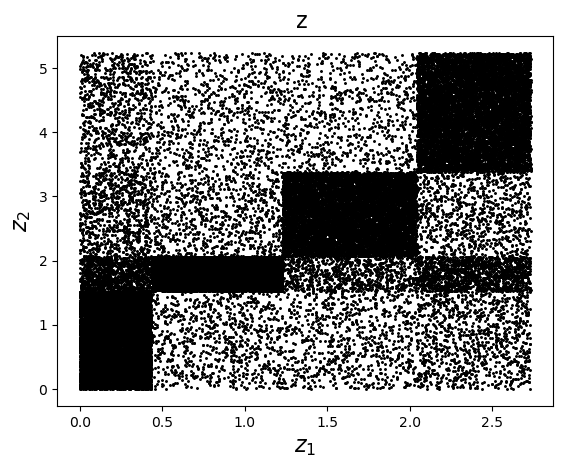

In [4]:
plot_datapoints(dset.z)
plt.xlabel(r"$z_1$", fontsize=16)
plt.ylabel(r"$z_2$", fontsize=16)
plt.title("z ", fontsize=16)

In [5]:
n_samples_grid = 20 # for plotting

In [6]:
separators = dset.separators
d_data, d_latent = dset.get_dims()

ftrue = dset.model
ftrue.to(device)
ftrue.train(mode=False)

sep_x = np.array(separators[0])
sep_y = np.array(separators[1])
n_separators = len(sep_x) + len(sep_y)
agg = aggregate_x_y(sep_x, sep_y, n_interm=n_samples_grid)
agg = torch.Tensor(agg)

grid_x_std, grid_y_std = normal_fine_grid(bound=3.5, data=dset.z,  n_points=n_samples_grid)
agg_grid = np.stack((grid_x_std, grid_y_std), axis=2) # aggregrate grid
agg_grid = torch.Tensor(agg_grid)

Text(0.5, 1.0, '$z_1$')

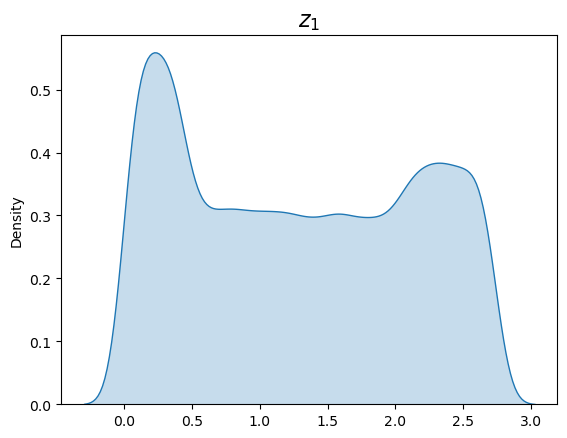

In [7]:
f = plt.figure()
sns.kdeplot(dset.z[:,0].cpu().numpy(), fill=True)
plt.title(r'$z_1$', fontsize=16)

Text(0.5, 1.0, '$z_2$')

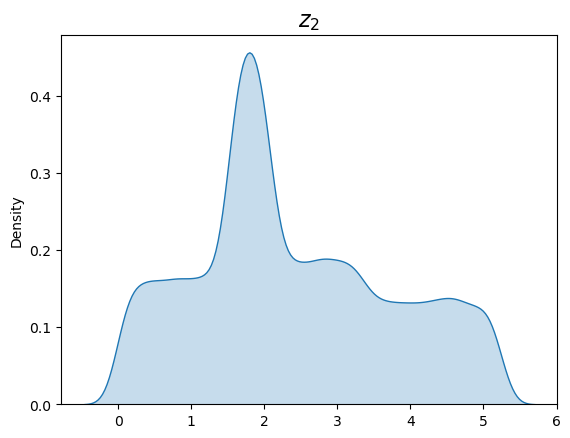

In [8]:
f = plt.figure()
sns.kdeplot(dset.z[:,1].cpu().numpy(), fill=True)
plt.title(r'$z_2$', fontsize=16)

In [9]:
z_true_standardized, true_fine_grid_standardized, true_separators_standardized, mean, std = standardize_for_plotting(dset.z, agg_grid, agg)

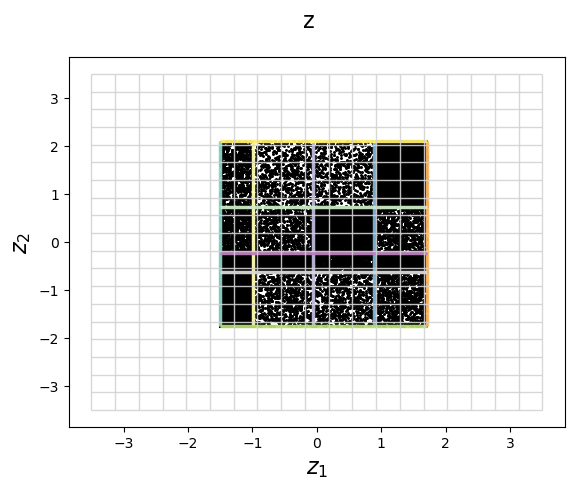

In [10]:
fig2, ax, ar = plot_grid_from_points(true_separators_standardized, alpha=0.95)
_ = plot_fine_grid(true_fine_grid_standardized, alpha=0.9, ax=ax)
plot_datapoints(z_true_standardized)
ax.set_xlabel(r'$z_1$', fontsize=16)
ax.set_ylabel(r'$z_2$', fontsize=16)
fig2.suptitle('z', fontsize=16)
plt.show()

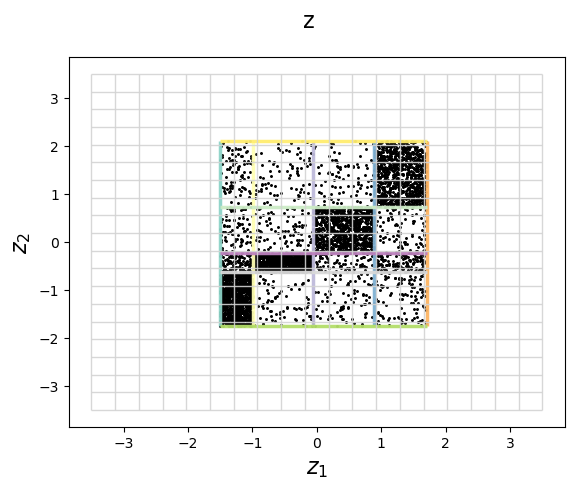

In [11]:
fig2, ax, ar = plot_grid_from_points(true_separators_standardized, alpha=0.95)
_ = plot_fine_grid(true_fine_grid_standardized, alpha=0.9, ax=ax)
plot_datapoints(z_true_standardized[0:5000])
ax.set_xlabel(r'$z_1$', fontsize=16)
ax.set_ylabel(r'$z_2$', fontsize=16)
fig2.suptitle('z', fontsize=16)
plt.show()

Correlation between the factors $z_1$ and $z_2$:

In [12]:
print("--- Correlation coefficient ", np.corrcoef(dset.z[:,0].cpu().numpy(), dset.z[:,1].cpu().numpy())[0,1], " ---")

--- Correlation coefficient  0.6419315362502244  ---


## Observed variables

In [13]:
x = dset.x

agg = torch.Tensor(agg)

nn = dset.model
separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
grid_x = nn(agg_grid.view(-1,2)).reshape(agg_grid.shape)

x_standardized, x_grid_standardized, x_separators_standardized, mean_x, std_x = standardize_for_plotting(x, grid_x, separators_x)

Text(0.5, 0.98, 'x')

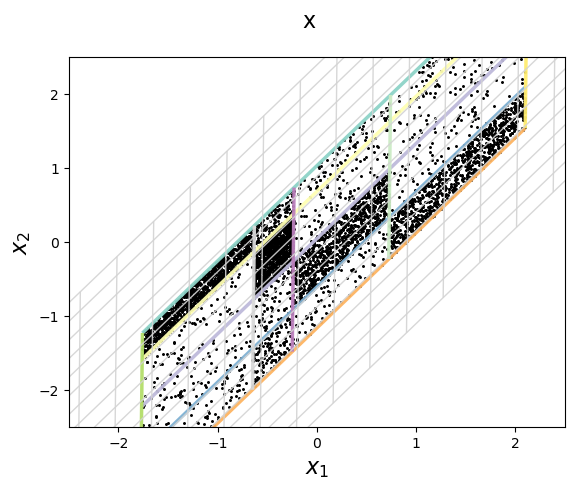

In [14]:
fig2, ax, ar = plot_grid_from_points(x_separators_standardized, alpha=0.95)
_ = plot_fine_grid(x_grid_standardized, alpha=0.9, ax=ax)
plot_datapoints(x_standardized[0:5000])
ax.set_xlabel(r'$x_1$', fontsize=16)
ax.set_ylabel(r'$x_2$', fontsize=16)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
fig2.suptitle('x', fontsize=16)

## Our algorithm

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader
from parzen import ParzenWindowsGaussian
from criterion import criterion, compute_alpha, compute_density_grad
from models import linear_transf

In [14]:
from utils import to_ndarray

In [15]:
# model initialization seed
seed = 4

In [16]:
np.random.seed(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

model=linear_transf()
model.to(device)
model.train(mode=True)

nn = dset.model
nn.to(device)
nn.train(mode=False)

linear_transf(
  (fc3): Linear(in_features=2, out_features=2, bias=False)
)

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [18]:
loader_params = {'num_workers': 6, 'pin_memory': True} if torch.cuda.is_available() else {}
data_loader = DataLoader(dset, batch_size=5000, shuffle=False, drop_last=True, **loader_params)

In [19]:
n_epochs = 200
sigma = 0.1

## plotting
arrow_scale = 500
n_samples_grid = 20 # for plotting

In [20]:
Xs, V, V_norms = compute_density_grad(dset.x, sigma=sigma, standardize=True, use_log_density=True)

alpha = compute_alpha(V_norms, alpha_mode='as_is', gamma=1.0, return_cdf=False)
dset.alpha = alpha

In [21]:
for epoch in range(1,n_epochs+1):  # loop over the dataset multiple times

    train_loss = 0.0

    for i, data in enumerate(data_loader):
        model.train(mode=True)
        x, z_true, alpha_batch = data
        x = x.to(device)
        alpha_batch = alpha_batch.to(device)

        optimizer.zero_grad(set_to_none=True)
        z_prime_orig = model(x)

        if i==0:
            if epoch==1:

                with torch.no_grad():
                    ## preprocess separators
                    sep_x = np.array(separators[0])
                    sep_y = np.array(separators[1])

                    agg = aggregate_x_y(sep_x, sep_y, n_interm=n_samples_grid)

                    ## create fine grid
                    grid_x_std, grid_y_std = normal_fine_grid(bound=2.2, data=dset.z,  n_points=n_samples_grid)
                    agg_grid = np.stack((grid_x_std, grid_y_std), axis=2) # aggregrate grid
                    agg_grid = torch.Tensor(agg_grid)
                    
                    z_true_standardized, true_fine_grid_standardized, true_separators_standardized, mean, std = standardize_for_plotting(z_true, agg_grid, agg)

                    estimator = ParzenWindowsGaussian(sigma) 
                    estimator.train(z_true_standardized)
                    log_grad = estimator.dlogp_dx(z_true_standardized)
                    loggrad = np.reshape(to_ndarray(log_grad), (z_true_standardized.shape[0], log_grad.shape[-1]))
                    dx = loggrad[:,0]
                    dy = loggrad[:,1]
                    magnitude = np.sqrt(dx**2+dy**2)

                    agg = torch.Tensor(agg)

                    separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
                    separators_x = nn(agg.view(-1,2)).reshape(agg.shape)
                    grid_x = nn(agg_grid.view(-1,2)).reshape(agg_grid.shape)

                    x_standardized, x_grid_standardized, x_separators_standardized, mean_x, std_x = standardize_for_plotting(x, grid_x, separators_x)      

            model.eval()
            with torch.no_grad():
                mcc_score = mcc(z_prime_orig.detach().cpu().numpy(), z_true.detach().cpu().numpy())
                print("MCC: ", mcc_score)


                separators_zprime = model(nn(agg.view(-1,2))).reshape(agg.shape)
                grid_zprime = model(nn(agg_grid.view(-1,2))).reshape(agg_grid.shape)


                z_prime_standardized, fine_grid_standardized, separators_standardized, mean, std = standardize_for_plotting(z_prime_orig, grid_zprime, separators_zprime)

        loss, loss_terms_dict, gradient_norms = criterion(X=z_prime_orig,
                                                                obs=x,
                                                                lambda_gr_local_align=-1,
                                                                lambda_gr_axis_align=1.0,
                                                                lambda_pts_axis_align=-1,
                                                                lambda_pts_gr_ortho=-1, 
                                                                lambda_rec=-1,
                                                                lambda_marginal=-1,
                                                                sigma_parzen=sigma, multiplicity=1, use_abs_cosine=False, 
                                                                gamma=1.0, require_neighbor_also_has_large_gradient=True,
                                                                use_log_density_gradient=True,
                                                                sampling_bandwidth=0.0,
                                                                alpha_mode="as_is",
                                                                compute_cdf=False,
                                                                sigma_neighbors=sigma,
                                                                standardize_batch=True,
                                                                gamma_robust=None,
                                                                alpha=alpha_batch)

        loss.backward(retain_graph=False)


        optimizer.step()

        train_loss += loss.item()

        

    train_loss /= len(data_loader)

    print('epoch', epoch,  '-- train_loss', train_loss)

MCC:  0.6416263002399257
epoch 1 -- train_loss -0.08807016950359126
MCC:  0.9963646327390511
epoch 2 -- train_loss -0.0927941714905764
MCC:  0.9975621346245787
epoch 3 -- train_loss -0.09350224128630542
MCC:  0.9994524686804354
epoch 4 -- train_loss -0.09352618578286831
MCC:  0.9985543393406587
epoch 5 -- train_loss -0.0935446565596563
MCC:  0.9999986970477965
epoch 6 -- train_loss -0.09355614389724448
MCC:  0.9991464633083158
epoch 7 -- train_loss -0.09354334510404907
MCC:  0.9979301492885599
epoch 8 -- train_loss -0.09350413561113967
MCC:  0.9996358429207639
epoch 9 -- train_loss -0.09357651611034958
MCC:  0.999260577815436
epoch 10 -- train_loss -0.09355618621919982
MCC:  0.9997597749193585
epoch 11 -- train_loss -0.09358607210523273
MCC:  0.9999419755413557
epoch 12 -- train_loss -0.09358821347760946
MCC:  0.9993204471204473
epoch 13 -- train_loss -0.09358227107041446
MCC:  0.9998430370240194
epoch 14 -- train_loss -0.09359550768616656
MCC:  0.9997697818163718
epoch 15 -- train_los

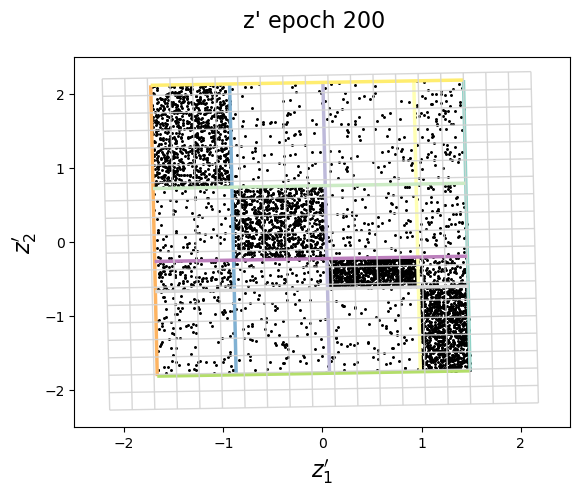

In [22]:
fig2, ax2, _ = plot_grid_from_points(separators_standardized, array=ar)
_ = plot_fine_grid(fine_grid_standardized, alpha=0.9, ax=ax2)
plot_datapoints(z_prime_standardized)
ax2.set_xlabel(r"$z_1'$", fontsize=16)
ax2.set_ylabel(r"$z_2'$", fontsize=16)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
fig2.suptitle("z\' epoch "+str(epoch), fontsize=16)
plt.show()

## ICA results

In [23]:
from sklearn.decomposition import FastICA

In [24]:
# model initialization seed
seed = 3

In [25]:
X = dset.x.cpu().detach().numpy()
transformer = FastICA(n_components=2, random_state=seed, whiten='unit-variance', max_iter=1000)
S_est = transformer.fit_transform(X)

In [26]:
mcc_score = mcc(S_est, dset.z.detach().cpu().numpy())
print("MCC: ", mcc_score)

MCC:  0.7611638686376063


In [27]:
# this matrix is already including the whitening!
unmixing_matrix_white = transformer.components_
unmixing_matrix_white = torch.Tensor(unmixing_matrix_white)

mixing = transformer.mixing_
mixing = torch.Tensor(mixing)

shift = transformer.mean_
shift = torch.Tensor(shift)

X = torch.tensor(X)
Z_ica = torch.matmul(X, unmixing_matrix_white)

In [28]:
xsep = ftrue(agg.view(-1,2).to(device)) - shift
xgrid = ftrue(agg_grid.view(-1,2).to(device)) - shift

separators_zprime = torch.matmul(unmixing_matrix_white, xsep.T ).T.reshape(true_separators_standardized.shape)
grid_zprime = torch.matmul(unmixing_matrix_white, xgrid.T ).T.reshape(true_fine_grid_standardized.shape)

In [29]:
# reduce the number of data samples for cleaner plot
S_est = S_est[0:5000]

z_prime_standardized, fine_grid_standardized, separators_standardized, mean, std = standardize_for_plotting(S_est, grid_zprime, separators_zprime)

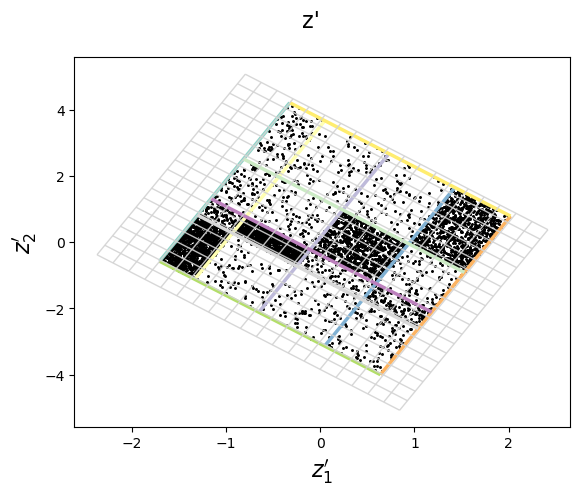

In [30]:
fig2, ax2, _ = plot_grid_from_points(separators_standardized, array=ar)
_ = plot_fine_grid(fine_grid_standardized, alpha=0.9, ax=ax2)
plot_datapoints(z_prime_standardized)
ax2.set_xlabel(r"$z_1'$", fontsize=16)
ax2.set_ylabel(r"$z_2'$", fontsize=16)
fig2.suptitle("z\' ", fontsize=16)
plt.show()

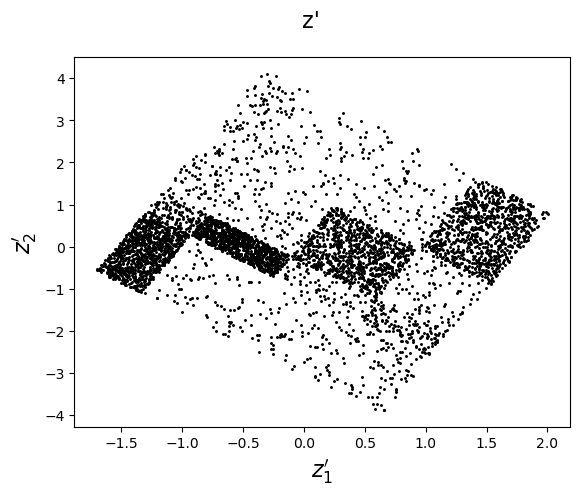

In [31]:
f, ax = plt.subplots()
plot_datapoints(z_prime_standardized)
ax.set_xlabel(r"$z_1'$", fontsize=16)
ax.set_ylabel(r"$z_2'$", fontsize=16)
f.suptitle("z\' ", fontsize=16)
plt.show()